## Chapter 2: machine learning for S&P500 prediction 

**by Li Shen, Ph.D.**

**E-mail: shenli.sam@gmail.com**

**LinkedIn: https://www.linkedin.com/in/lshen**

**Updated: 2016/06/01**

## Summary

In this chapter, machine learning techniques are used to predict the log returns of the daily close prices of S&P500. Two families of machine learning methods are considered, i.e. Support Vector Machines (SVMs) and decision tree ensembles, including random forest and extra trees. The machine learning methods are used to either directly predict the log returns or combine with the ARMA predictions in a hybrid fashion from the previous chapter. It is found that with the direct approach, the machine learning methods may perform worse than the ARMA method and the results are highly variable. While with the hybrid approach, the results are less variable and the machine learning methods can perform as well as or better than the ARMA method. It is also found that the random forest performs extremely well at 21d and 42d time horizons but its performance quickly degrades at 64d time horizon.

### Load data and libraries

In [264]:
%pylab inline
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


First, load the S&P500 daily log return data saved from previous chapter, including the ARMA residuals. This dataset includes the daily closing prices of S&P500 from 2012/06/01 to 2014/08/30, of which the time period of 2012/06/01-2014/05/31 is used as train set and the time period of 2014/06/01-2014/08/30 is used as test set.

In [265]:
ts_logrt = pd.read_csv('ts_logrt.csv')
ts_logrt = pd.DataFrame(ts_logrt['sp500_logrt'].values, 
                        index=pd.to_datetime(ts_logrt['Date']), 
                        columns=['sp500_logrt'])
arma_all_resid = np.load('arma_all_resid.npy')
split_date = '2014-06-01'
lrt_train = ts_logrt[:split_date]
lrt_test = ts_logrt[split_date:]

### 2.1 Lagged data and feature selection

#### 2.1.1 Lagged log return data

To apply machine learning, we must first decide what are predictors and targets. Here, I use 20 lagged log returns as predictors and the log return on the current day as target. 20 is an arbitrary choice but shall be large enough to include all the historical correlations. We may use all 20 days' data as predictors or only part of them. I'll leave it to the feature selection to decide.

In [527]:
lag_winsize = 20
lagged_lrt_df = concatenate(
    map(lambda x: ts_logrt.ix[range(x - 1, x - 1 - lag_winsize, -1), 0], 
        range(lag_winsize, ts_logrt.shape[0]))
).reshape((-1, lag_winsize))
lagnames = map(lambda x: 'L' + str(x), range(1, lag_winsize + 1))
lagged_lrt_df = pd.DataFrame(lagged_lrt_df, index=ts_logrt.index[lag_winsize:], 
                             columns=lagnames)
print 'Dimensions of lagged log return data:', lagged_lrt_df.shape
lagged_lrt_df.head(n=3)

Dimensions of lagged log return data: (648, 20)


,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
Date,,,,,,,,,,,,,,,,,,,,
2012-02-02,0.008860,-0.000457,-0.002525,-0.001594,-0.005771,0.008642,-0.001026,0.000471,0.000669,0.004927,0.011047,0.003547,-0.004960,0.002334,0.000310,0.008847,0.002259,-0.002540,0.002939,0.000188
2012-02-03,0.001095,0.008860,-0.000457,-0.002525,-0.001594,-0.005771,0.008642,-0.001026,0.000471,0.000669,0.004927,0.011047,0.003547,-0.004960,0.002334,0.000310,0.008847,0.002259,-0.002540,0.002939
2012-02-06,0.014500,0.001095,0.008860,-0.000457,-0.002525,-0.001594,-0.005771,0.008642,-0.001026,0.000471,0.000669,0.004927,0.011047,0.003547,-0.004960,0.002334,0.000310,0.008847,0.002259,-0.002540


In [267]:
lagged_lrt_train = lagged_lrt_df[:split_date]
lagged_lrt_test = lagged_lrt_df[split_date:]
print 'Train set shape:', lagged_lrt_train.shape
print 'Test set shape:', lagged_lrt_test.shape

Train set shape: (584, 20)
Test set shape: (64, 20)


To improve optimization, scale the train set predictors to have zero mean and unit variance. Apply the same scaling to the test predictors as well.

In [268]:
from sklearn import preprocessing
llrt_scaler = preprocessing.StandardScaler().fit(lagged_lrt_train)
llrt_train_scaled = llrt_scaler.transform(lagged_lrt_train)
llrt_test_scaled = llrt_scaler.transform(lagged_lrt_test)

Create log return targets.

In [269]:
llrt_train_y = lrt_train[lag_winsize:].values.ravel()
llrt_test_y = lrt_test.values.ravel()

Calculate and visualize the correlation coefficients between the 20 predictors on the train set.

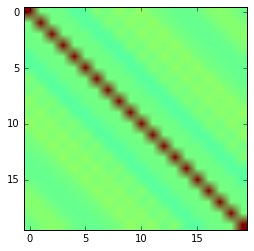

In [530]:
llrt_train_cor = pd.DataFrame(corrcoef(llrt_train_scaled, rowvar=False), 
                              index=lagnames, columns=lagnames)
imshow(llrt_train_cor, vmin=-1, vmax=1)

Looks like the predictors have extremely weak correlations with each other so we shall not concern about multicollinearity.

Calculate the dot products between all train set samples. This will help me decide how to choose hyperparameters when using kernel functions.

In [483]:
llrt_train_dot = dot(llrt_train_scaled, llrt_train_scaled.T)
print '== log return train set dot product (normalized) stats: =='
print 'Max:', llrt_train_dot.max()/llrt_train_scaled.shape[1]
print 'Min:', llrt_train_dot.min()/llrt_train_scaled.shape[1]

== log return train set dot product (normalized) stats: ==
Max: 2.71704332143
Min: -1.36103003841


#### 2.1.2 Lagged ARMA residuals

Use the same procedure as above on the ARMA residuals to set up predictors and targets, and then apply normalization. The purpose will become more clear when using a hybrid approach to combine ARMA and other machine learning methods.

In [271]:
arma_train_resid = np.load('arma_train_resid.npy')
arma_test_resid = np.load('arma_test_resid.npy')
arma_all_resid = concatenate((arma_train_resid, arma_test_resid))
lagged_resid_df = concatenate(
    map(lambda x: arma_all_resid[range(x - 1, x - 1 - lag_winsize, -1)], 
        range(lag_winsize, len(arma_all_resid)))
).reshape((-1, lag_winsize))
lagged_resid_df = pd.DataFrame(lagged_resid_df, index=ts_logrt.index[lag_winsize:], 
                               columns=lagnames)
lagged_resid_train = lagged_resid_df[:split_date]
lagged_resid_test = lagged_resid_df[split_date:]
lresid_scaler = preprocessing.StandardScaler().fit(lagged_resid_train)
lresid_train_scaled = lresid_scaler.transform(lagged_resid_train)
lresid_test_scaled = lresid_scaler.transform(lagged_resid_test)
lresid_train_y = arma_train_resid[lag_winsize:]
lresid_test_y = arma_test_resid

In [484]:
lresid_train_dot = dot(lresid_train_scaled, lresid_train_scaled.T)
print '== ARMA residual train set dot product (normalized) stats: =='
print 'Max:', lresid_train_dot.max()/lresid_train_scaled.shape[1]
print 'Min:', lresid_train_dot.min()/lresid_train_scaled.shape[1]

== ARMA residual train set dot product (normalized) stats: ==
Max: 2.77696251554
Min: -1.31883071914


#### 2.1.3 Assess feature importance with randomized Lasso and random forest

There is no pre-assumption regarding which lagged values are more useful than others as predictors for log returns. So here I'll use two feature selection methods - randomized Lasso and random forest to assess them.

In [272]:
from sklearn.linear_model import RandomizedLasso
import warnings
rand_lasso = RandomizedLasso(n_resampling=3000, normalize=False, random_state=1, n_jobs=2)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rand_lasso.fit(llrt_train_scaled, llrt_train_y)

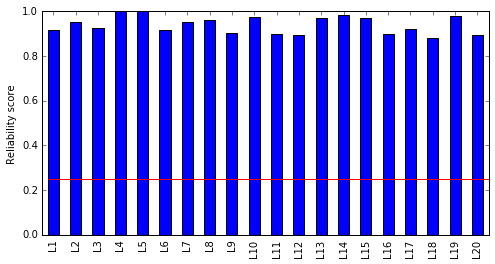

In [536]:
lasso_scores = pd.DataFrame(rand_lasso.scores_, index=lagnames, 
                            columns=['reliability score'])
lasso_scores.plot(kind='bar', legend=False, figsize=[8, 4])
hlines(y=.25, xmin=-.25, xmax=lag_winsize - .25, colors='r')
ylabel('Reliability score')

There is really no distinction in reliability scores among the 20 lagged predictors and they are all well above the default 0.25 cutoff.

Now, use random forest to calculate feature importances. A potential advantage of random forest is that it may capture nonliearities in the data, while Lasso assumes linear dependencies.

In [274]:
from sklearn.ensemble import RandomForestRegressor
rand_forest = RandomForestRegressor(n_estimators=3000, n_jobs=2, random_state=1)
rand_forest.fit(llrt_train_scaled, llrt_train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=3000, n_jobs=2, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

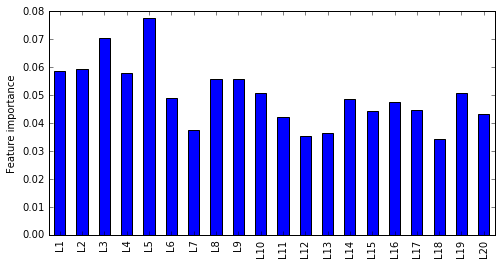

In [537]:
rf_scores = pd.DataFrame(rand_forest.feature_importances_, index=lagnames, 
                            columns=['feature importance'])
rf_scores.plot(kind='bar', legend=False, figsize=[8, 4])
ylabel('Feature importance')

There are no clear winners in feature importances: the largest value is only about 2 times larger than the smallest value. However, the plot seems to suggest that recent lags are more important than remote lags.

The same feature selection procedure can be applied to the ARMA residuals:

In [538]:
rand_lasso_r = RandomizedLasso(n_resampling=3000, normalize=False, random_state=1, n_jobs=2)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rand_lasso_r.fit(lresid_train_scaled, lresid_train_y)
print "Randomized Lasso stability scores:"
print rand_lasso_r.scores_
rand_forest_r = RandomForestRegressor(n_estimators=3000, n_jobs=2, random_state=1)
rand_forest_r.fit(lresid_train_scaled, lresid_train_y)
print ''
print "Random forest feature importance scores:"
print rand_forest_r.feature_importances_

Randomized Lasso stability scores:
[ 0.86733333  0.86766667  0.89033333  0.99333333  0.98366667  0.93666667
  0.85033333  0.98633333  0.86166667  0.996       0.855       0.85133333
  0.901       0.92666667  0.878       0.89        0.95033333  0.85
  0.92933333  0.86233333]

Random forest feature importance scores:
[ 0.05273698  0.06074853  0.06985319  0.05327494  0.0715813   0.04877357
  0.03721937  0.05763945  0.05390337  0.0571669   0.03906505  0.04031639
  0.03549864  0.05056883  0.04805786  0.04761804  0.04811024  0.03349766
  0.0486274   0.0457423 ]


The patterns seem to be similar to the log return data. Well, they should be.

### 2.2 Support vector machines

Now, I'm going to use support vector machines to predict the log returns. Before doing that, let me load the previous ARMA's predictions and re-evaluate them at different time horizons. This can be important because a model's performance can be varied at different time horizons.

In [469]:
arma_train_pred = np.load('arma_train_pred.npy')
arma_test_pred = np.load('arma_test_pred.npy')
horzn_list = [21, 42, 64]  # time horizon in business days.
arma_horizon_score = pd.DataFrame(index=['ARMA'], columns=horzn_list)
for h in horzn_list:
    arma_horizon_score.ix['ARMA', h] = r2_score(llrt_test_y[:h], arma_test_pred[:h])
arma_horizon_score

,21,42,64
ARMA,0.00499219,0.0207266,0.0237322


The ARMA R2 scores somehow increase over time. This seems to be contrary to common belief. Since R2 score is not a very robust measure, this may be simply explained by variance. On the other hand, this suggests that the patterns captured by ARMA are robust and can last for a while.

The ARMA performance is served as a baseline for other machine learning methods. 

In addition to ARMA, I'll also use a dummy regressor to create another baseline.

In [470]:
from sklearn.dummy import DummyRegressor
dum_reg = DummyRegressor('mean')
dum_reg.fit(llrt_train_scaled, llrt_train_y)
dumreg_test_pred = dum_reg.predict(llrt_test_scaled)
dumreg_horizon_score = pd.DataFrame(index=['DummyRegressor'], columns=horzn_list)
for h in horzn_list:
    dumreg_horizon_score.ix['DummyRegressor', h] = r2_score(llrt_test_y[:h], 
                                                            dumreg_test_pred[:h])
dumreg_horizon_score

,21,42,64
DummyRegressor,-0.00534342,-0.000257202,-6.91409e-07


The dummy regressor produces negative R2 scores at all time horizons.

In the following, I'll write a subclass of the SVR class in sklearn. The only change I made is to add the number of lags as an argument. This allows me to tune this important value as a hyperparameter, just like other hyperparameters, such as `C` and `epsilon`.

In [281]:
from sklearn.svm import SVR
class SVRLagSelector(SVR):
    '''SVR subclass that allows the number of lagged predictors 
    as a parameter.
    '''
    def __init__(self, nlag=None, kernel='rbf', degree=3, gamma='auto', coef0=0.0,
                 tol=1e-3, C=1.0, epsilon=0.1, shrinking=True,
                 cache_size=200, verbose=False, max_iter=-1):
        super(SVRLagSelector, self).__init__(
            kernel=kernel, degree=degree, gamma=gamma, coef0=coef0,
            tol=tol, C=C, epsilon=epsilon, shrinking=shrinking,
            cache_size=cache_size, verbose=verbose, max_iter=max_iter)
        self.nlag = nlag
        
    def fit(self, X, y, sample_weight=None):
        assert self.nlag <= X.shape[1]
        return super(SVRLagSelector, 
                     self).fit(X[:, :self.nlag], y, sample_weight)
    
    def predict(self, X):
        assert self.nlag <= X.shape[1]
        return super(SVRLagSelector, 
                     self).predict(X[:, :self.nlag])
    
    def score(self, X, y, sample_weight=None):
        assert self.nlag <= X.shape[1]
        return super(SVRLagSelector, 
                     self).score(X[:, :self.nlag], y, sample_weight)   

I'll apply SVMs using two approaches - *direct* and *hybrid*. In direct approach, I will build a regressor to directly predict log returns. In hybrid approach, I will build a regressor to predict ARMA residuals first, and then combine the predictions with ARMA predictions. This approach takes advantage of both ARMA and other machine learning techniques.

#### 2.2.1 Direct approach

The following code uses a grid search to find the best hyperparameters for SVMs and was run on a workstation due to computational cost. Since the train set has a small effective sample size, I put an emphasis on reducing variance and choose `C` from -15 to -1 and raise it to the power of 10. The `epsilon` is chosen from -15 to -2 and raise to the power of 10, which means the largest `epsilon` is 0.01. This is because most log returns are small with the largest log return being around 0.02. I also let the number of lags be from [5, 10, 15, 20]. 

All 4 kernels that are available from sklearn, i.e. linear, poly, rbf and sigmoid are used.

```python
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sys import stdout
from time import time

#### Load data and setup ####
d = np.load('lagged_traintest.npz')
C_list = 10.**np.arange(-15, 0)
eps_list = 10.**np.arange(-15, -1)
nlag_list = range(5, 21, 5)
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']
tune_params = {'C': C_list, 'epsilon': eps_list, 'nlag': nlag_list}
tune_params_poly = tune_params.copy()
tune_params_poly['degree'] = range(2, 5)
n_cvfolds = 10
n_maxiters = 10e6

#### Direct approach ####
svm_r2_df = pd.DataFrame(index=kernel_list, columns=['train_r2', 'test_r2'])
start = time()
for kernel in kernel_list:
    if kernel == 'poly':
        reg = GridSearchCV(SVRLagSelector(kernel=kernel, max_iter=n_maxiters), 
                           tune_params_poly, cv=n_cvfolds, n_jobs=6)
    else:
        reg = GridSearchCV(SVRLagSelector(kernel=kernel, max_iter=n_maxiters), 
                           tune_params, cv=n_cvfolds, n_jobs=6)
    reg.fit(d['llrt_train_scaled'], d['llrt_train_y'])
    print 'Best parameters for %s kernel:' % (kernel), reg.best_params_
    stdout.flush()
    svm_r2_df.ix[kernel, 'train_r2'] = reg.score(d['llrt_train_scaled'], 
                                                 d['llrt_train_y'])
    svm_r2_df.ix[kernel, 'test_r2'] = reg.score(d['llrt_test_scaled'], 
                                                d['llrt_test_y'])
print 'Time cost for grid search:', time() - start
svm_r2_df.to_csv('svm_r2_df.csv')
```

Here are the best parameters found for different kernels by grid search:

Kernel|Best params
------|-----------
linear|{'epsilon': 0.001, 'C': 1e-7, 'nlag': 5}
poly|{'epsilon': 1e-05, 'C': 0.0001, 'nlag': 15, 'degree': 2}
rbf|{'epsilon': 0.001, 'C': 0.0001, 'nlag': 15}
sigmoid|{'epsilon': 0.0001, 'C': 1e-15, 'nlag': 5}

The chosen parameter values are within the search range with only one exception. The `C` for the sigmoid kernel hits the left boundary. However, decreasing `C` did not seem to change the result. I think `1e-15` was chosen instead of `1e-14` simply because it is the first value to consider. `1e-15` is already a very small value, anyway. So I decided not to expand the search range further.

Load the saved R2 scores on both train and test sets.

In [471]:
svm_r2_df = pd.read_csv('svm_r2_df.csv', index_col=0)
svm_r2_df

,train_r2,test_r2
linear,0.000063,-0.000254
poly,0.027798,-0.003249
rbf,0.016679,0.009271
sigmoid,-0.000290,-0.000639


Looks like the SVMs did a bad job in forecasting log returns with close to zero R2 scores on the test set. There is also evidence of overfitting even though the parameters were tuned by grid search. 

Now, take a look of the R2 scores at different time horizons.

In [472]:
svm_linear_reg = SVRLagSelector(kernel='linear', max_iter=10e6, 
                                epsilon=0.001, C=1e-7, nlag=5)
svm_poly_reg = SVRLagSelector(kernel='poly', max_iter=10e6, 
                              epsilon=1e-5, C=0.0001, nlag=15, degree=2)
svm_rbf_reg = SVRLagSelector(kernel='rbf', max_iter=10e6, 
                             epsilon=0.001, C=0.0001, nlag=15)
svm_sigmoid_reg = SVRLagSelector(kernel='sigmoid', max_iter=10e6, 
                                 epsilon=0.0001, C=1e-15, nlag=5)
svm_kernel_list = {'linear': svm_linear_reg, 'poly': svm_poly_reg, 
                   'rbf': svm_rbf_reg, 'sigmoid': svm_sigmoid_reg}
horzn_list = [21, 42, 64]  # time horizon in business days.
svm_score_horizon = pd.DataFrame(index=svm_kernel_list.keys(), 
                                 columns=horzn_list)
for name, reg in svm_kernel_list.items():
    reg.fit(llrt_train_scaled, llrt_train_y)
    pred = reg.predict(llrt_test_scaled)
    for h in horzn_list:
        svm_score_horizon.ix[name, h] = r2_score(llrt_test_y[:h], pred[:h])
svm_score_horizon

,21,42,64
rbf,0.0145431,0.0139753,0.00927064
linear,-0.00210715,-0.000678203,-0.000254168
poly,-0.0251774,0.000544545,-0.00324935
sigmoid,-0.00136966,-0.00203189,-0.000639116


Overall, the performance is bad for all kernels at all horizons.

#### 2.2.2 Hybrid approach

The hybrid approach is inspired by this paper: *G. Peter Zhang, Time series forecasting using a hybrid ARIMA and neural network model, Neurocomputing, Volume 50, January 2003, Pages 159-175.* There are many similar studies in the literature.

```python
#### Hybrid approach ####
hyb_svm_r2_df = pd.DataFrame(index=kernel_list, columns=['train_r2', 'test_r2'])
start = time()
for kernel in kernel_list:
    if kernel == 'poly':
        reg = GridSearchCV(SVRLagSelector(kernel=kernel, max_iter=n_maxiters), 
                           tune_params_poly, cv=n_cvfolds, n_jobs=6)
    else:
        reg = GridSearchCV(SVRLagSelector(kernel=kernel, max_iter=n_maxiters), 
                           tune_params, cv=n_cvfolds, n_jobs=6)
    reg.fit(d['lresid_train_scaled'], d['lresid_train_y'])
    print 'Best parameters for %s kernel:' % (kernel), reg.best_params_
    stdout.flush()
    hyb_train_pred = d['arma_train_pred'][d['lag_winsize']:] \
                     + reg.predict(d['lresid_train_scaled'])
    hyb_test_pred = d['arma_test_pred'] + reg.predict(d['lresid_test_scaled'])
    hyb_svm_r2_df.ix[kernel, 'train_r2'] = r2_score(d['llrt_train_y'], 
                                                    hyb_train_pred)
    hyb_svm_r2_df.ix[kernel, 'test_r2'] = r2_score(d['llrt_test_y'], 
                                                   hyb_test_pred)
print 'Time cost for grid search:', time() - start
hyb_svm_r2_df.to_csv('hyb_svm_r2_df.csv')
```

The best parameters found by grid search for different kernels:

Kernel|Best params
------|-----------
linear|{'epsilon': 0.0001, 'C': 1e-15, 'nlag': 10}
poly|{'epsilon': 1e-14, 'C': 0.0001, 'nlag': 15, 'degree': 2}
rbf|{'epsilon': 0.0001, 'C': 1e-15, 'nlag': 5}
sigmoid|{'epsilon': 0.0001, 'C': 1e-15, 'nlag': 5}

In [473]:
hyb_svm_r2_df = pd.read_csv('hyb_svm_r2_df.csv', index_col=0)
hyb_svm_r2_df

,train_r2,test_r2
linear,0.014911,0.023009
poly,0.039928,0.015256
rbf,0.014949,0.022854
sigmoid,0.014172,0.024103


This time, the performance has improved a lot with three kernels achieving >0.02 R2 scores on the test set! The worst performing kernel is the polynomial kernel that shows a sign of overfitting.

It's also worthwhile to check the hybrid SVMs' performance at different time horizons.

In [542]:
svm_linear_reg = SVRLagSelector(kernel='linear', max_iter=10e6, 
                                epsilon=0.0001, C=1e-15, nlag=10)
svm_poly_reg = SVRLagSelector(kernel='poly', max_iter=10e6, 
                              epsilon=1e-14, C=0.0001, nlag=15, degree=2)
svm_rbf_reg = SVRLagSelector(kernel='rbf', max_iter=10e6, 
                             epsilon=0.0001, C=1e-15, nlag=5)
svm_sigmoid_reg = SVRLagSelector(kernel='sigmoid', max_iter=10e6, 
                                 epsilon=0.0001, C=1e-15, nlag=5)
svm_kernel_list = {'linear': svm_linear_reg, 'poly': svm_poly_reg, 
                   'rbf': svm_rbf_reg, 'sigmoid': svm_sigmoid_reg}
horzn_list = [21, 42, 64]  # time horizon in business days.
svm_score_horizon = pd.DataFrame(index=svm_kernel_list.keys(), 
                                 columns=horzn_list)
for name, reg in svm_kernel_list.items():
    reg.fit(lresid_train_scaled, lresid_train_y)
    pred = arma_test_pred + reg.predict(lresid_test_scaled)
    for h in horzn_list:
        svm_score_horizon.ix[name, h] = r2_score(llrt_test_y[:h], pred[:h])
svm_score_horizon

,21,42,64
rbf,-0.00340703,0.0178851,0.0228536
linear,-0.00212572,0.0183375,0.0230094
poly,-0.0271564,0.0127941,0.0152562
sigmoid,0.0108441,0.0224954,0.0241027


The sigmoid SVM seems to improve the ARMA's performance at all time horizons.

Because the sigmoid kernel looks most promising among all, I'll finetune its parameters to see if any improvement can be made. The idea is to seach around the vicinity of the original best parameters to see if a better performing model can be found. I also added `gamma` and `coef0`, which were not tuned in the previous search.

In [501]:
gamma_choices = ['auto']
gamma_choices.extend((10.**arange(-5, 2)).tolist())
params_grid = {'epsilon': 2.**arange(log2(0.0001) - 2, log2(0.0001) + 3), 
               'nlag': range(1, 10, 2), 
               'gamma': gamma_choices, 
               'coef0': range(-10, 11, 2)}
sv_reg = SVRLagSelector(kernel='sigmoid', max_iter=10e6, C=1e-15)
sv_gs_resid = GridSearchCV(sv_reg, params_grid, cv=10, n_jobs=-1)
start = time()
sv_gs_resid.fit(lresid_train_scaled, lresid_train_y)
print 'Time cost for grid search:', time() - start
print 'Best params for SVM sigmoid:', sv_gs_resid.best_params_

Time cost for grid search: 171.067161083
Best params for SVM sigmoid: {'epsilon': 0.00020000000000000009, 'nlag': 7, 'coef0': -2, 'gamma': 0.0001}


Looks like the grid search found a new set of parameters that improved the R2 score in cross-validation.

Evaluate the performance of the orignal best parameters and the refined best parameters on residuals forecasting.

In [503]:
sv_resid_r2 = pd.DataFrame(index=['orig', 'refined'], 
                           columns=['cross-validation R2', 'train R2', 'test R2'])
sv_resid_orig = SVRLagSelector(kernel='sigmoid', max_iter=-1, 
                               epsilon=0.0001, C=1e-15, nlag=5)
cvp = cross_val_predict(sv_resid_orig, lresid_train_scaled, lresid_train_y, 
                        cv=10, n_jobs=-1)
sv_resid_r2.ix['orig', 'cross-validation R2'] = r2_score(lresid_train_y, cvp)
sv_resid_orig.fit(lresid_train_scaled, lresid_train_y)
sv_resid_r2.ix['orig', 'train R2'] = sv_resid_orig.score(lresid_train_scaled, 
                                                         lresid_train_y)
sv_resid_r2.ix['orig', 'test R2'] = sv_resid_orig.score(lresid_test_scaled, 
                                                        lresid_test_y)
##
sv_resid_refined = SVRLagSelector(kernel='sigmoid', max_iter=-1, 
                                  epsilon=0.0002, C=1e-15, nlag=7, 
                                  coef0=-2, gamma=0.0001)
cvp = cross_val_predict(sv_resid_refined, lresid_train_scaled, lresid_train_y, 
                        cv=10, n_jobs=-1)
sv_resid_r2.ix['refined', 'cross-validation R2'] = r2_score(lresid_train_y, cvp)
sv_resid_refined.fit(lresid_train_scaled, lresid_train_y)
sv_resid_r2.ix['refined', 'train R2'] = sv_resid_refined.score(lresid_train_scaled, 
                                                               lresid_train_y)
sv_resid_r2.ix['refined', 'test R2'] = sv_resid_refined.score(lresid_test_scaled, 
                                                              lresid_test_y)
sv_resid_r2

,cross-validation R2,train R2,test R2
orig,-0.00470781,-0.000924013,-0.000101989
refined,-0.00186126,-0.00013496,-0.00138199


The refined parameters show some improvement on the cross-validation R2 score but did worse on the test R2 score.

Now, evalute the performance on log returns forecasting.

In [505]:
sv_lrt_r2 = pd.DataFrame(index=['orig', 'refined'], 
                         columns=['train R2', 'test R2'])
sv_train_pred_orig = arma_train_pred[lag_winsize:]\
                     + sv_resid_orig.predict(lresid_train_scaled)
sv_test_pred_orig = arma_test_pred\
                    + sv_resid_orig.predict(lresid_test_scaled)
sv_lrt_r2.ix['orig', 'train R2'] = r2_score(llrt_train_y, sv_train_pred_orig)
sv_lrt_r2.ix['orig', 'test R2'] = r2_score(llrt_test_y, sv_test_pred_orig)
##
sv_train_pred_refined = arma_train_pred[lag_winsize:]\
                        + sv_resid_refined.predict(lresid_train_scaled)
sv_test_pred_refined = arma_test_pred\
                        + sv_resid_refined.predict(lresid_test_scaled)
sv_lrt_r2.ix['refined', 'train R2'] = r2_score(llrt_train_y, sv_train_pred_refined)
sv_lrt_r2.ix['refined', 'test R2'] = r2_score(llrt_test_y, sv_test_pred_refined)
sv_lrt_r2

,train R2,test R2
orig,0.0141717,0.0241027
refined,0.0149489,0.0228536


Again, the refined parameters show no improvement.

In [506]:
horzn_list = [21, 42, 64]  # time horizon in business days.
sv_horizon_score = pd.DataFrame(index=['orig', 'refined'], columns=horzn_list)
for h in horzn_list:
    sv_horizon_score.ix['orig', h] = r2_score(llrt_test_y[:h], 
                                              sv_test_pred_orig[:h])
    sv_horizon_score.ix['refined', h] = r2_score(llrt_test_y[:h], 
                                                 sv_test_pred_refined[:h])
sv_horizon_score

,21,42,64
orig,0.0108441,0.0224954,0.0241027
refined,-0.00340703,0.0178851,0.0228536


Lastly, the refined parameters did not improve the performance at any time horizon.

### 2.3 Random forest and extra trees

The ensemble of decision trees is a class of popular machine learning methods that usually generalize very well. Here I consider two ensemble methods - extra trees and random forest. The extra trees method is a variant of the random forest, in which the cutoff values are randomly generated (instead of optimized) each time the nodes are split. This change makes the generated trees more stochastic than the optimized trees in a random forest and is supposed to reduce variance.

Same as above, I'll define subclasses for the `ExtraTreesRegressor` and the `RandomForestRegressor` classes in sklearn, which allow me to tune the number of lags as a hyperparameter.

In [540]:
from sklearn.ensemble import ExtraTreesRegressor
class ETLagSelector(ExtraTreesRegressor):
    '''ExtraTreesRegressor subclass that allows the number of 
    lagged predictors as a parameter.
    '''
    def __init__(self, nlag=None, n_estimators=10, criterion="mse",
                 max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 min_weight_fraction_leaf=0., max_features="auto",
                 max_leaf_nodes=None, bootstrap=False, oob_score=False,
                 n_jobs=1, random_state=None, verbose=0, warm_start=False):
        super(ETLagSelector, self).__init__(
            n_estimators=n_estimators, 
            criterion=criterion, 
            max_depth=max_depth,
            min_samples_split=min_samples_split, 
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf, 
            max_features=max_features,
            max_leaf_nodes=max_leaf_nodes, 
            bootstrap=bootstrap, 
            oob_score=oob_score,
            n_jobs=n_jobs, 
            random_state=random_state, 
            verbose=verbose, 
            warm_start=warm_start)
        self.nlag = nlag
        
    def apply(self, X):
        assert self.nlag <= X.shape[1]
        return super(ETLagSelector, self).apply(X[:, :self.nlag])
    
    def fit(self, X, y, sample_weight=None):
        assert self.nlag <= X.shape[1]
        return super(ETLagSelector, 
                     self).fit(X[:, :self.nlag], y, sample_weight)
    
    def fit_transform(self, X, y=None):
        assert self.nlag <= X.shape[1]
        return super(ETLagSelector, 
                     self).fit_transform(X[:, :self.nlag], y)
    
    def predict(self, X):
        assert self.nlag <= X.shape[1]
        return super(ETLagSelector, 
                     self).predict(X[:, :self.nlag])
    
    def score(self, X, y, sample_weight=None):
        assert self.nlag <= X.shape[1]
        return super(ETLagSelector, 
                     self).score(X[:, :self.nlag], y, sample_weight)

In [452]:
from sklearn.ensemble import RandomForestRegressor
class RFLagSelector(RandomForestRegressor):
    '''RandomForestRegressor subclass that allows the number of 
    lagged predictors as a parameter.
    '''
    def __init__(self, nlag=None, n_estimators=10, criterion="mse",
                 max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 min_weight_fraction_leaf=0., max_features="auto",
                 max_leaf_nodes=None, bootstrap=True, oob_score=False,
                 n_jobs=1, random_state=None, verbose=0, warm_start=False):
        super(RFLagSelector, self).__init__(
            n_estimators=n_estimators, 
            criterion=criterion, 
            max_depth=max_depth,
            min_samples_split=min_samples_split, 
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf, 
            max_features=max_features,
            max_leaf_nodes=max_leaf_nodes, 
            bootstrap=bootstrap, 
            oob_score=oob_score,
            n_jobs=n_jobs, 
            random_state=random_state, 
            verbose=verbose, 
            warm_start=warm_start)
        self.nlag = nlag
        
    def apply(self, X):
        assert self.nlag <= X.shape[1]
        return super(RFLagSelector, self).apply(X[:, :self.nlag])
    
    def fit(self, X, y, sample_weight=None):
        assert self.nlag <= X.shape[1]
        return super(RFLagSelector, 
                     self).fit(X[:, :self.nlag], y, sample_weight)
    
    def fit_transform(self, X, y=None):
        assert self.nlag <= X.shape[1]
        return super(RFLagSelector, 
                     self).fit_transform(X[:, :self.nlag], y)
    
    def predict(self, X):
        assert self.nlag <= X.shape[1]
        return super(RFLagSelector, 
                     self).predict(X[:, :self.nlag])
    
    def score(self, X, y, sample_weight=None):
        assert self.nlag <= X.shape[1]
        return super(RFLagSelector, 
                     self).score(X[:, :self.nlag], y, sample_weight)

The most important parameter for an ensemble of trees is the maximum number of features to consider for each tree. Here, I tune it as a portion of the predictors from 0.1 to 1.0 in an increment of 0.1. I also tune the minimum number of samples to be from 1 to 64 in a power 2 series for each leaf. For each ensemble, 500 trees are generated.

#### 2.3.1 Direct approach

```python
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sys import stdout
from time import time

#### Load data and setup ####
d = np.load('lagged_traintest.npz')
tree_list = {'rf': RFLagSelector, 'et': ETLagSelector}
maxfea_list = np.linspace(.1, 1., 10)
minsam_list = 2**np.arange(0, 7)
nlag_list = range(5, 21, 5)
tune_params = {'max_features': maxfea_list, 'min_samples_leaf': minsam_list, 
               'nlag': nlag_list}
n_cvfolds = 10
n_estimators = 500

#### Direct approach ####
tree_r2_df = pd.DataFrame(index=tree_list.keys(), 
                          columns=['train_r2', 'test_r2'])
start = time()
for name, tree in tree_list.items():
    reg = GridSearchCV(tree(n_estimators=n_estimators, random_state=1), 
                       tune_params, cv=n_cvfolds, n_jobs=6)
    reg.fit(d['llrt_train_scaled'], d['llrt_train_y'])
    print 'Best parameters for %s:' % (name), reg.best_params_
    stdout.flush()
    tree_r2_df.ix[name, 'train_r2'] = reg.score(d['llrt_train_scaled'], 
                                                d['llrt_train_y'])
    tree_r2_df.ix[name, 'test_r2'] = reg.score(d['llrt_test_scaled'], 
                                               d['llrt_test_y'])
print 'Time cost for grid search:', time() - start
tree_r2_df.to_csv('tree_r2_df.csv')
```

The best parameters found by grid search are:

Method|Parameters
------|----------
Extra trees|{'max_features': 0.4, 'nlag': 5, 'min_samples_leaf': 4}
Random forest|{'max_features': 0.1, 'nlag': 15, 'min_samples_leaf': 16}

In [543]:
tree_r2_df = pd.read_csv('tree_r2_df.csv', index_col=0)
tree_r2_df

,train_r2,test_r2
et,0.228954,-0.056826
rf,0.155554,0.014934


Looks like both ensemble methods suffer from overfitting, while the random forest suffers less than the extra trees. This seems to be contrary to the promise of the extra trees. 

Now, re-build the two ensemble models using the parameters found by the grid search and evaluate them using cross-validation and at different time horizons.

In [546]:
et_reg = ETLagSelector(n_estimators=500, random_state=1, 
                       max_features=.4, nlag=5, min_samples_leaf=4)
rf_reg = RFLagSelector(n_estimators=500, random_state=1, 
                       max_features=.1, nlag=15, min_samples_leaf=16)
eval_list = ['cross-validation', 21, 42, 64]
trees_score = pd.DataFrame(index=['ExtraTrees', 'RandomForest'], 
                           columns=eval_list)
cvp = cross_val_predict(et_reg, llrt_train_scaled, llrt_train_y, cv=10, n_jobs=-1)
trees_score.ix['ExtraTrees', 'cross-validation'] = r2_score(llrt_train_y, cvp)
cvp = cross_val_predict(rf_reg, llrt_train_scaled, llrt_train_y, cv=10, n_jobs=-1)
trees_score.ix['RandomForest', 'cross-validation'] = r2_score(llrt_train_y, cvp)
et_reg.fit(llrt_train_scaled, llrt_train_y)
et_test_pred = et_reg.predict(llrt_test_scaled)
rf_reg.fit(llrt_train_scaled, llrt_train_y)
rf_test_pred = rf_reg.predict(llrt_test_scaled)
for h in eval_list[1:]:
    trees_score.ix['ExtraTrees', h] = r2_score(llrt_test_y[:h], et_test_pred[:h])
    trees_score.ix['RandomForest', h] = r2_score(llrt_test_y[:h], rf_test_pred[:h])
trees_score

,cross-validation,21,42,64
ExtraTrees,0.00543001,-0.021403,0.0605764,-0.0568264
RandomForest,0.000429987,0.122874,0.0803118,0.0149337


The above result is quite surprising: in cross-validation, it seems the extra trees did slightly better than the random forest but it did not correlate with the test scores; at 21 and 42 days, the random forest did extremely well but the R2 score quickly decreased at 64 days; the extra trees had a nice R2 score at 42 days but negative R2 scores at 21 and 64 days. The result shows large variance for both ensemble methods.

Since the above result is so intriguing, let me plot the squared errors of both ensemble methods and the ARMA model along time.

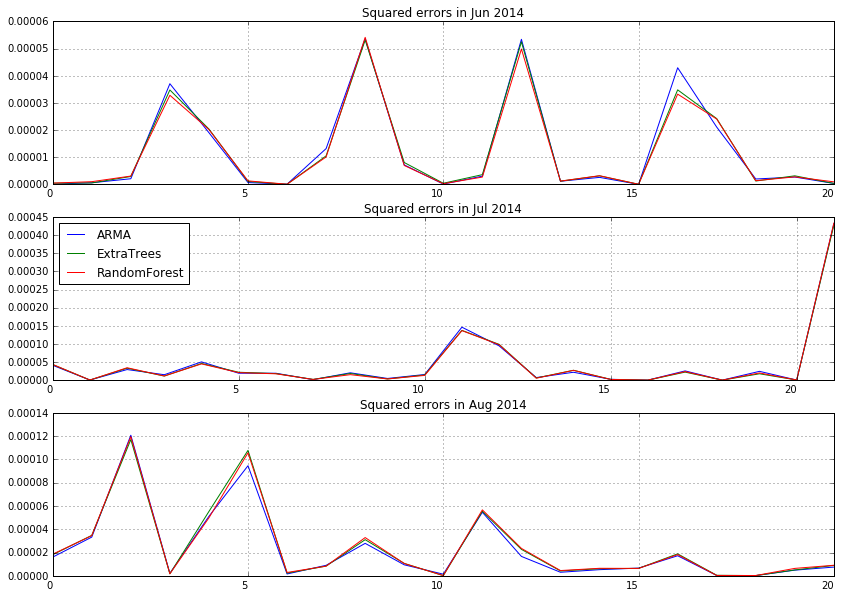

In [550]:
sq_err_rf = (llrt_test_y - rf_test_pred)**2
sq_err_et = (llrt_test_y - et_test_pred)**2
sq_err_arma = arma_test_resid**2
sq_err_time = pd.DataFrame(c_[sq_err_arma, sq_err_et, sq_err_rf], 
                           index=lrt_test.index, 
                           columns=['ARMA', 'ExtraTrees', 'RandomForest'])
fig,axes = subplots(3, 1)
fig.set_size_inches([14, 11])
sq_err_time['2014-06'].plot(ax=axes[0], grid=True, title='Squared errors in Jun 2014', 
                            use_index=False, rot=0, legend=False)
sq_err_time['2014-07'].plot(ax=axes[1], grid=True, title='Squared errors in Jul 2014', 
                            use_index=False, rot=0)
sq_err_time['2014-08'].plot(ax=axes[2], grid=True, title='Squared errors in Aug 2014', 
                            use_index=False, rot=0, legend=False)

It can be seen that the random forest was able to produce lower squared errors than both ARMA and the extra trees on most days in Jun and Jul. Also, the extra trees correlated with the random forest in squared errors. However, ARMA produced lower squared errors than both ensemble methods in Aug, which eventually made it outperform them on the whole test set.

#### 2.3.2 Hybrid approach

```python
#### Hybrid approach ####
hyb_tree_r2_df = pd.DataFrame(index=tree_list.keys(), 
                              columns=['train_r2', 'test_r2'])
start = time()
for name, tree in tree_list.items():
    reg = GridSearchCV(tree(n_estimators=n_estimators, random_state=1), 
                       tune_params, cv=n_cvfolds, n_jobs=6)
    reg.fit(d['lresid_train_scaled'], d['lresid_train_y'])
    print 'Best parameters for %s:' % (name), reg.best_params_
    stdout.flush()
    hyb_train_pred = d['arma_train_pred'][d['lag_winsize']:] \
                     + reg.predict(d['lresid_train_scaled'])
    hyb_test_pred = d['arma_test_pred'] + reg.predict(d['lresid_test_scaled'])
    hyb_tree_r2_df.ix[name, 'train_r2'] = r2_score(d['llrt_train_y'], 
                                                   hyb_train_pred)
    hyb_tree_r2_df.ix[name, 'test_r2'] = r2_score(d['llrt_test_y'], 
                                                  hyb_test_pred)
print 'Time cost for grid search:', time() - start
hyb_tree_r2_df.to_csv('hyb_tree_r2_df.csv')
```

The best parameters found by grid search are:

Method|Parameters
------|----------
Extra trees|{'max_features': 0.4, 'nlag': 10, 'min_samples_leaf': 32}
Random forest|{'max_features': 0.1, 'nlag': 10, 'min_samples_leaf': 64}

In [547]:
hyb_tree_r2_df = pd.read_csv('hyb_tree_r2_df.csv', index_col=0)
hyb_tree_r2_df

,train_r2,test_r2
et,0.043945,0.020106
rf,0.044424,0.022894


Using hybrid approach, both ensemble methods suffer less from overfitting than direct approach. Again, rebuild the two models and evaluate them at cross-validation and different time horizons.

In [549]:
et_reg = ETLagSelector(n_estimators=500, random_state=1, 
                       max_features=.4, nlag=10, min_samples_leaf=32)
rf_reg = RFLagSelector(n_estimators=500, random_state=1, 
                       max_features=.1, nlag=10, min_samples_leaf=64)
eval_list = ['cross-validation', 21, 42, 64]
trees_score = pd.DataFrame(index=['ExtraTrees', 'RandomForest'], 
                           columns=eval_list)
cvp = cross_val_predict(et_reg, lresid_train_scaled, lresid_train_y, cv=10, n_jobs=-1)
cvp += arma_train_pred[lag_winsize:]
trees_score.ix['ExtraTrees', 'cross-validation'] = r2_score(llrt_train_y, cvp)
cvp = cross_val_predict(rf_reg, lresid_train_scaled, lresid_train_y, cv=10, n_jobs=-1)
cvp += arma_train_pred[lag_winsize:]
trees_score.ix['RandomForest', 'cross-validation'] = r2_score(llrt_train_y, cvp)
et_reg.fit(lresid_train_scaled, lresid_train_y)
et_test_pred = et_reg.predict(lresid_test_scaled) + arma_test_pred
rf_reg.fit(lresid_train_scaled, lresid_train_y)
rf_test_pred = rf_reg.predict(lresid_test_scaled) + arma_test_pred
for h in eval_list[1:]:
    trees_score.ix['ExtraTrees', h] = r2_score(llrt_test_y[:h], et_test_pred[:h])
    trees_score.ix['RandomForest', h] = r2_score(llrt_test_y[:h], rf_test_pred[:h])
trees_score

,cross-validation,21,42,64
ExtraTrees,0.0127541,0.0293641,0.046976,0.0201061
RandomForest,0.00659209,0.0550102,0.0608721,0.0228937


The above result shows exactly the same pattern as the result in the direct approach. In cross-validation, the extra trees did better than the random forest but that did not correlate with the test scores. The random forest did extremely well at 21 and 42 days but the score decreased at 64 days. While the extra trees did best at the 42 days. Overall, the hybrid approach shows less variance than the direct approach.

## Discussion

It is particularly concerning and puzzling that the cross-validation scores do not correlate well with the test scores on the S&P500 log return data. This makes hyperparameters tuning difficult since it depends on the cross-validation result. One can reason that the classic way of doing cross-validation does not work with time series data, which assumes the sampels to be **i.i.d.** A possible remedy is to weight the train samples so that the squared errors of the more remote samples are less weighted. This way, we can tune the parameters to emphasize more on the more recent train samples, which are presumably more relevant to the test samples. Similarly, the train samples can be weighted in the loss functions of machine learning algorithms. This weighting strategy may be explored in future chapters.